In [771]:
import tweetdf
import geopandas
import pandas
import trips
import odm
import sampers
import matplotlib.pyplot as plt
import matplotlib as mpl
import partition
import numpy as np
import odm_similarity
from shapely.geometry import Point
import importlib
importlib.reload(partition)
importlib.reload(odm_similarity)

<module 'odm_similarity' from '/Users/kristofferek/Documents/git/mscthesis/src/py/odm_similarity.py'>

In [727]:
region = 'national'
beta = 0.03

# Partition tweets into Samper's grid system

In this notebook we extract displacements from tweets in a region, and construct an ODM based on the grids used by Samper's model.

In [728]:
tweets = tweetdf.from_csv("./../../dbs/Sweden.csv")
tweets.shape

(1302359, 9)

1,3 Million geotagged tweets (by users with a detected home location in Sweden)

In [729]:
tweets = tweets.dropna()
tweets.shape

(1302358, 9)

## Extract displacements
Currently, we consider two consecutive stays to be a displacement if and only if the time between them is less than 12 hours.

In [730]:
displacements = trips.from_dfs(tweets)
displacements.shape

(554716, 10)

Construct ODM without aggregation into zones (based on lat/long)

In [732]:
latlngodm = odm.from_trips(displacements)
latlngodm.head()

,latitude_o,longitude_o,latitude_d,longitude_d,count
0,-79.898133,-49.192753,59.350000,18.066667,1
1,-54.809017,-68.302105,-54.808049,-68.307551,1
2,-54.808219,-68.318154,-54.809017,-68.302105,1
3,-54.808049,-68.307551,-54.783803,-68.259351,1
4,-54.805765,-68.307080,-54.783803,-68.259351,1


In [678]:
shp = sampers.read_shp(sampers.shps[region])
shp.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The above dataset defines the zones used by Samper's model.

Low resolution shape of sweden.

In [477]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

## ODM construction
Aggregate displacements into origin and destination zones from Samper's model.

In [772]:
odm_twitter_df = partition.convert_to_zones(latlngodm, sweden, shp)
odm_twitter_df

,ozone,dzone,count
0,971141,971141,1379
1,971141,971151,6
2,971141,971231,3
3,971141,971232,6
4,971141,971233,2
...,...,...,...
14403,995847,971803,1
14404,995847,995843,1
14405,995847,995844,1
14406,995847,995846,1


In [751]:
zones_to_index = odm_similarity.shape_to_zone_dictionary(shp)

### Convert dataframe to OD matrix

In [773]:
odm_twitter_mat = odm_similarity.od_df_to_od_matrix(odm_twitter_df, zones_to_index, 'count')
odm_twitter_mat.shape

(682, 682)

### Load data from Samper's and place in OD matrix.

In [ ]:
odm_sampers_df = sampers.read_odm(sampers.odms[region])
odm_sampers_mat = odm_similarity.od_df_to_od_matrix(odm_sampers_df, zones_to_index, 'total')
odm_sampers_mat.shape

## Plot OD matrices

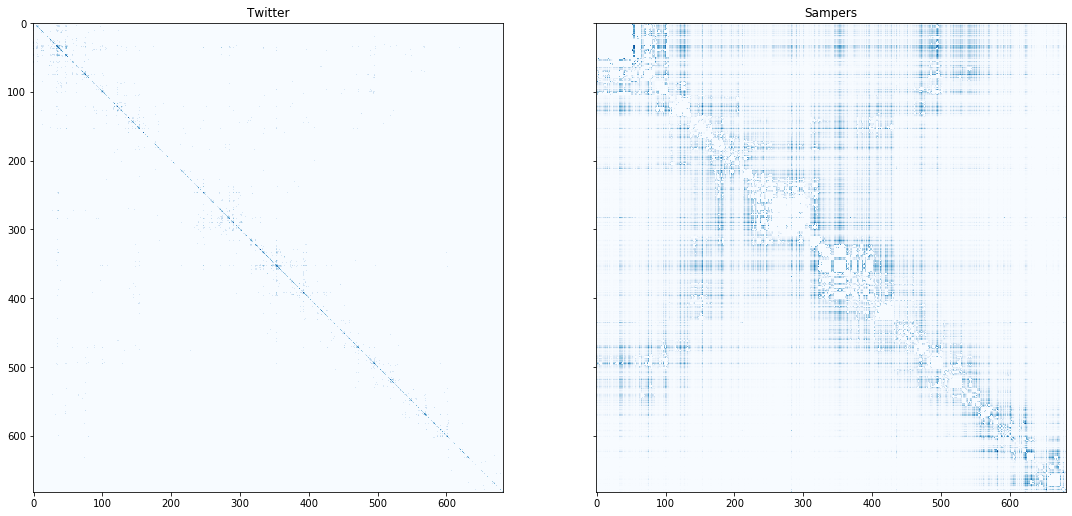

In [774]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(zone_mat_tw, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=odm_twitter.max()['count']), cmap='Blues')
ax2.imshow(zone_mat_samp, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(zone_mat_samp)), cmap='Blues')
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [777]:
importlib.reload(odm_similarity)
spssim_mean, spssim_share_mean, df_comp, OD_gt, OD_tw = odm_similarity.similarity(odm_sampers_df, odm_twitter_df, shp, region)

Similarity: 0.33098743227352373 Similarity weighted by travel demand: 0.28866909452426
Similarity by distance group:
                                      d_range  freq     share    SpSSIM
0                (100.0, 101.48346321226603)    55  0.021710  0.285162
1   (101.48346321226603, 102.75669500232641)    53  0.014376  0.304730
2   (102.75669500232641, 104.25158413641631)    54  0.017536  0.254818
3   (104.25158413641631, 105.77956625436951)    55  0.016570  0.290656
4   (105.77956625436951, 107.41665810338506)    54  0.016111  0.246810
..                                       ...   ...       ...       ...
95    (529.7706573691464, 562.1671986653209)    53  0.004336  0.534671
96    (562.1671986653209, 608.7861430736261)    54  0.003514  0.636508
97      (608.7861430736261, 666.90015206831)    55  0.003003  0.705692
98      (666.90015206831, 884.5024320503828)    53  0.005161  0.448042
99   (884.5024320503828, 1434.9855207861208)    56  0.001921  0.854256

[100 rows x 4 columns]


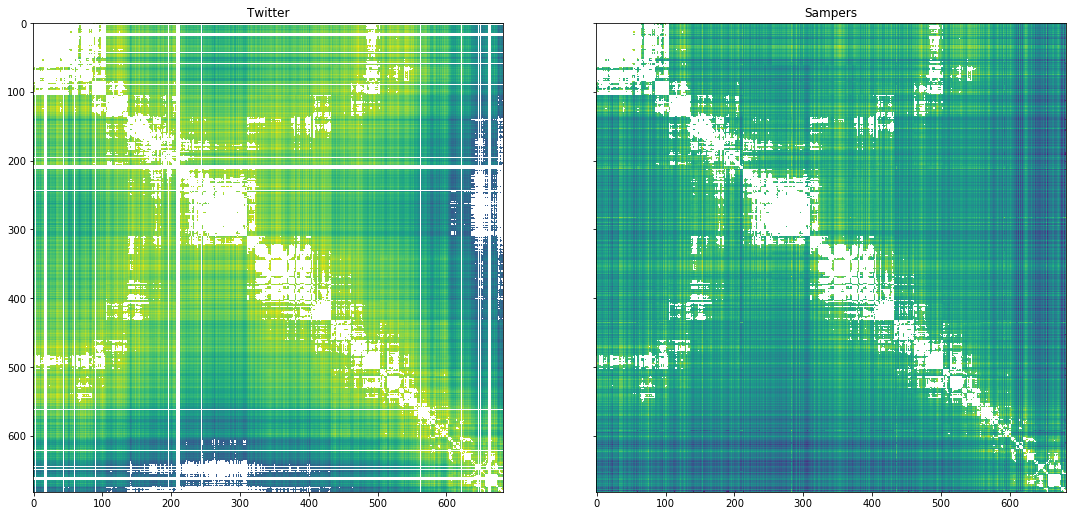

In [778]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(OD_tw, norm = mpl.colors.LogNorm())
ax2.imshow(OD_gt, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()